# CatBoost
This code contains the CatBoost modeling and plotting visualization process used in the paper.

In [2]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200 # Increase to high DPI resolution.
# plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['sans-serif', 'DejaVu Sans', 'sans']
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['text.usetex'] = True
shap.initjs()

In [37]:
# Load the comment data from news articles related to energy transition.
df = pd.read_csv('./data/reply_df_catboost.csv')
df.head()

,idx,reply_user_id,reply,Neutral,Non-Moral-Emotion,Condemning,Praising,Suffering,Self-Conscious,user_type,...,Condemning_past,Praising_past,Suffering_past,Self-Conscious_past,tokens_len,ttr,tokens_len_past,ttr_past,n_good,n_bad
0,0,NXIM,문죄인 지가 가동중단 건설중단 시켜서 수천억 혈세 날려놓고 이제와서 뭐가어째? 윤석...,0.095336,0.149919,0.997376,0.006453,0.004827,0.036101,normal,...,0.996458,0.006610,0.007246,0.036747,42,0.857143,23.0,0.937500,1574,13
1,0,2Mh8r,"5년임기 내내 ""탈원전"" 을 부르짖었던 사람이..임기 한달 남겨두고 180도 달라지...",0.055879,0.117007,0.998107,0.004667,0.007348,0.129774,normal,...,0.996991,0.006886,0.010434,0.033848,59,0.847458,68.0,0.764706,972,6
2,0,81WDL,문재앙은 원전 태양광 게이트만 제대로 수사받아도 평생 들어가 있을듯,0.200772,0.222707,0.993367,0.008692,0.004229,0.011016,normal,...,0.991683,0.014616,0.017001,0.079302,17,1.000000,22.5,0.967742,517,5
3,0,vHmK,우리는 역사에서 지난 5년을 잃어 버렸다.,0.454929,0.903803,0.621771,0.031186,0.391626,0.315763,normal,...,0.996046,0.006134,0.008331,0.035738,15,1.000000,27.0,0.913043,353,7
4,219,vHmK,원전 정지에 가담한 사람들 사법처리하고 국민앞에 사죄하고 올려줄지 말지 부탁해라,0.166623,0.122665,0.995902,0.005379,0.004839,0.027142,normal,...,0.996046,0.006134,0.008331,0.035738,27,0.777778,27.0,0.913043,372,6


In [38]:
df.columns

Index(['idx', 'reply_user_id', 'reply', 'Neutral', 'Non-Moral-Emotion',
       'Condemning', 'Praising', 'Suffering', 'Self-Conscious', 'user_type',
       'title_p/n', 'e_policy_p/n', 'politics', 'economy', 'society',
       'culture', 'international', 'sports', 'IT_science', 'Neutral_past',
       'Non-Moral-Emotion_past', 'Condemning_past', 'Praising_past',
       'Suffering_past', 'Self-Conscious_past', 'tokens_len', 'ttr',
       'tokens_len_past', 'ttr_past', 'n_good', 'n_bad'],
      dtype='object')

In [39]:
# dropna
df = df.dropna().reset_index(drop=True)

In [40]:
# Categorize news article titles.
df.loc[df['title_p/n']==-1.0,'title_p/n'] = 'negative'
df.loc[df['title_p/n']==0.0,'title_p/n'] = 'neutral'
df.loc[df['title_p/n']==1.0,'title_p/n'] = 'positive'
df['title_p/n'] = df['title_p/n'].astype('category')

In [41]:
# Categorize news article policy.
df.loc[df['e_policy_p/n']==-1.0,'e_policy_p/n'] = 'negative'
df.loc[df['e_policy_p/n']==0.0,'e_policy_p/n'] = 'neutral'
df.loc[df['e_policy_p/n']==1.0,'e_policy_p/n'] = 'positive'
df['e_policy_p/n'] = df['e_policy_p/n'].astype('category')

In [42]:
# Categorize user type (heavy or regular) as a nominal variable.
df['user_type'] = df['user_type'].astype('category')

### Model 1: Dependent variable "Condemning"

In [43]:
# Creating data features.
X_1 = df[['user_type', 'title_p/n', 'e_policy_p/n', 
         'politics', 'economy','society', 'culture', 'international', 'sports', 'IT_science', \
        'Condemning_past','Praising_past', 'Suffering_past', 'Self-Conscious_past',
        'tokens_len_past', 'ttr_past']]
y_1 = df['Condemning'].tolist()

In [44]:
# Split into training and test sets
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=2023)

# Specify indices for categorical variables (0,1,2)
cat_features = [0,1,2]

In [45]:
# Convert to CatBoost Pool format
train_pool_1 = Pool(X_train_1, y_train_1, cat_features=cat_features)
test_pool_1 = Pool(X_test_1, y_test_1, cat_features=cat_features)

In [46]:
# Model initialization
model_1 = CatBoostRegressor(iterations=1000, learning_rate=0.1, verbose=200)

In [47]:
# Train
model_1.fit(train_pool_1, eval_set=test_pool_1)

0:	learn: 0.1769864	test: 0.1839232	best: 0.1839232 (0)	total: 11.8ms	remaining: 11.8s
200:	learn: 0.1650128	test: 0.1775848	best: 0.1773270 (126)	total: 1.39s	remaining: 5.52s
400:	learn: 0.1593299	test: 0.1780661	best: 0.1773270 (126)	total: 2.8s	remaining: 4.19s
600:	learn: 0.1551040	test: 0.1785499	best: 0.1773270 (126)	total: 4.18s	remaining: 2.78s
800:	learn: 0.1513327	test: 0.1788808	best: 0.1773270 (126)	total: 5.58s	remaining: 1.39s
999:	learn: 0.1482321	test: 0.1790463	best: 0.1773270 (126)	total: 7s	remaining: 0us

bestTest = 0.1773269972
bestIteration = 126

Shrink model to first 127 iterations.


In [39]:
# save model
# model_1.save_model('./catboost_model/condemning.model')

In [25]:
# Predict
y_pred_1 = model_1.predict(X_test_1)

# R-squared
print("R-squared: {:.3f}".format(r2_score(y_test_1, y_pred_1)))

# Adjusted R2
n = X_test_1.shape[0]
k = X_test_1.shape[1]
adjusted_r2 = 1 - (1 - r2_score(y_test_1, y_pred_1)) * (n - 1) / (n - k - 1)
print("Adj R-squared: {:.3f}".format(adjusted_r2))

# MAPE
print("MAPE: {:.3f}".format(mean_absolute_percentage_error(y_test_1, y_pred_1)))

# Normalized MAE
# Calculate MAE
mae = np.mean(np.abs(y_test_1 - y_pred_1))
# Normalize MAE by the range of the dependent variable (Max - Min)
normalized_mae_range = mae / (np.max(y_test_1) - np.min(y_test_1))

# Normalize MAE by the standard deviation of the dependent variable
normalized_mae_std = mae / np.std(y_test_1)
print("Normalized MAE: {:.3f}".format(normalized_mae_range))
print("Normalized_std MAE: {:.3f}".format(normalized_mae_std))

# Calculate Coefficient of Variation of the RMSE (CV-RMSE)
print("CV-RMSE: {:.3f}".format(mean_squared_error(y_test_1, y_pred_1, squared=False) / np.mean(y_test_1)))

R-squared: 0.082
Adj R-squared: 0.080
MAPE: 1.033
Normalized MAE: 0.088
Normalized_std MAE: 0.475
CV-RMSE: 0.189


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


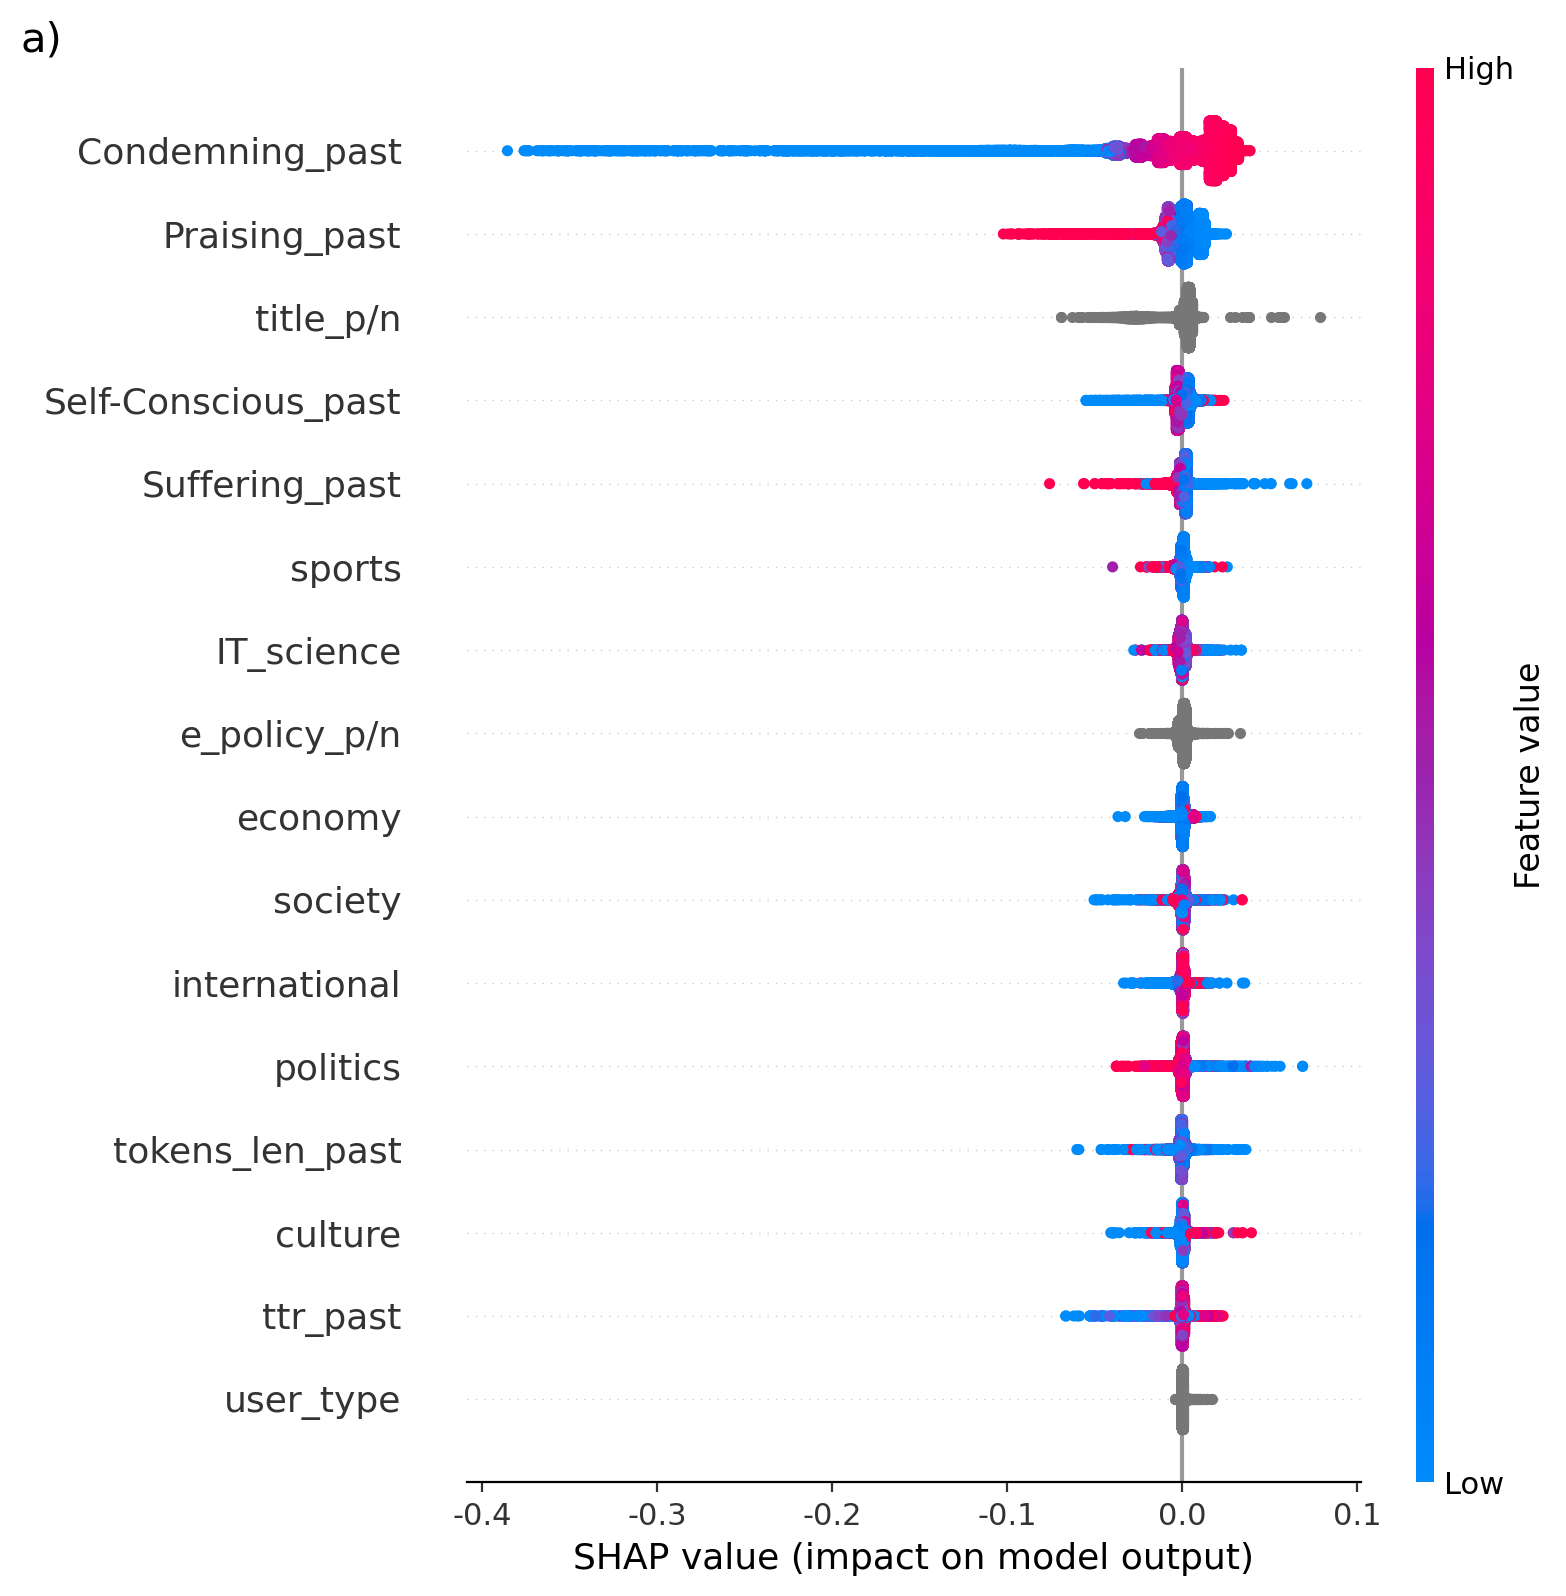

In [99]:
# Get and plot SHAP values
explainer_1 = shap.Explainer(model_1)   
shap_values_1 = explainer_1(X_1)
shap.summary_plot(shap_values_1, X_1,show=False)

# Setting the title with custom alignment
title = plt.title("a)", fontsize=15)
title.set_position([-0.5,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')
plt.show()

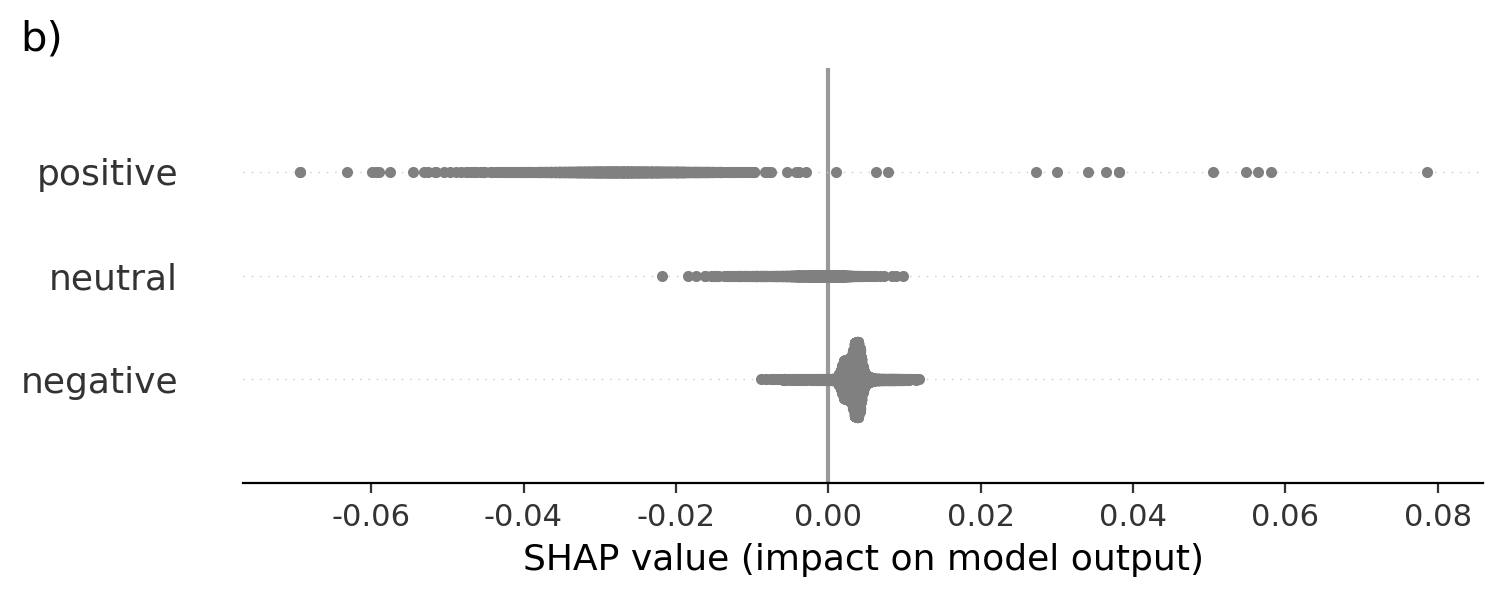

In [103]:
# https://github.com/conorosully/medium-articles/blob/master/src/interpretable%20ml/SHAP/SHAP_catboost.ipynb

#Create for placeholder SHAP values
shap_values_cate_1 = explainer_1(X_1)

#Get shaply values and feature values for odor
odor_values = np.array(shap_values_1[:,'title_p/n'].values) 
odor_data = X_1['title_p/n']

#Create new SHAP values array

#Split odor SHAP values by unique odor categories
unique_odor = list(X_1['title_p/n'].unique())
new_shap_values = [np.array(pd.Series(odor_values)[odor_data==odor]) for odor in unique_odor]

#Each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

#replace shap values
shap_values_cate_1.values = np.array(new_shap_values)

#replace data with placeholder array
shap_values_cate_1.data = np.array([[0]*len(unique_odor)]*max_len)

#replace base data with placeholder array
shap_values_cate_1.base = np.array([0]*max_len)

#replace feature names with category labels
# odor_labels = {'a':'almond',
#                'l':'anise', 
#                'c':'creosote', 
#                'y':'fishy', 
#                'f':'foul', 
#                'm':'musty', 
#                'n':'none', 
#                'p':'pungent', 
#                's':'spicy'}
# labels = ["{} ({})".format(odor_labels[u],u) for u in unique_odor]
shap_values_cate_1.feature_names = unique_odor

#Use besswarm as before
shap.plots.beeswarm(shap_values_cate_1, color_bar=False,show=False, color='#808080')

# Setting the title with custom alignment
title = plt.title("b)", fontsize=15)
title.set_position([-0.18,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')

plt.show()

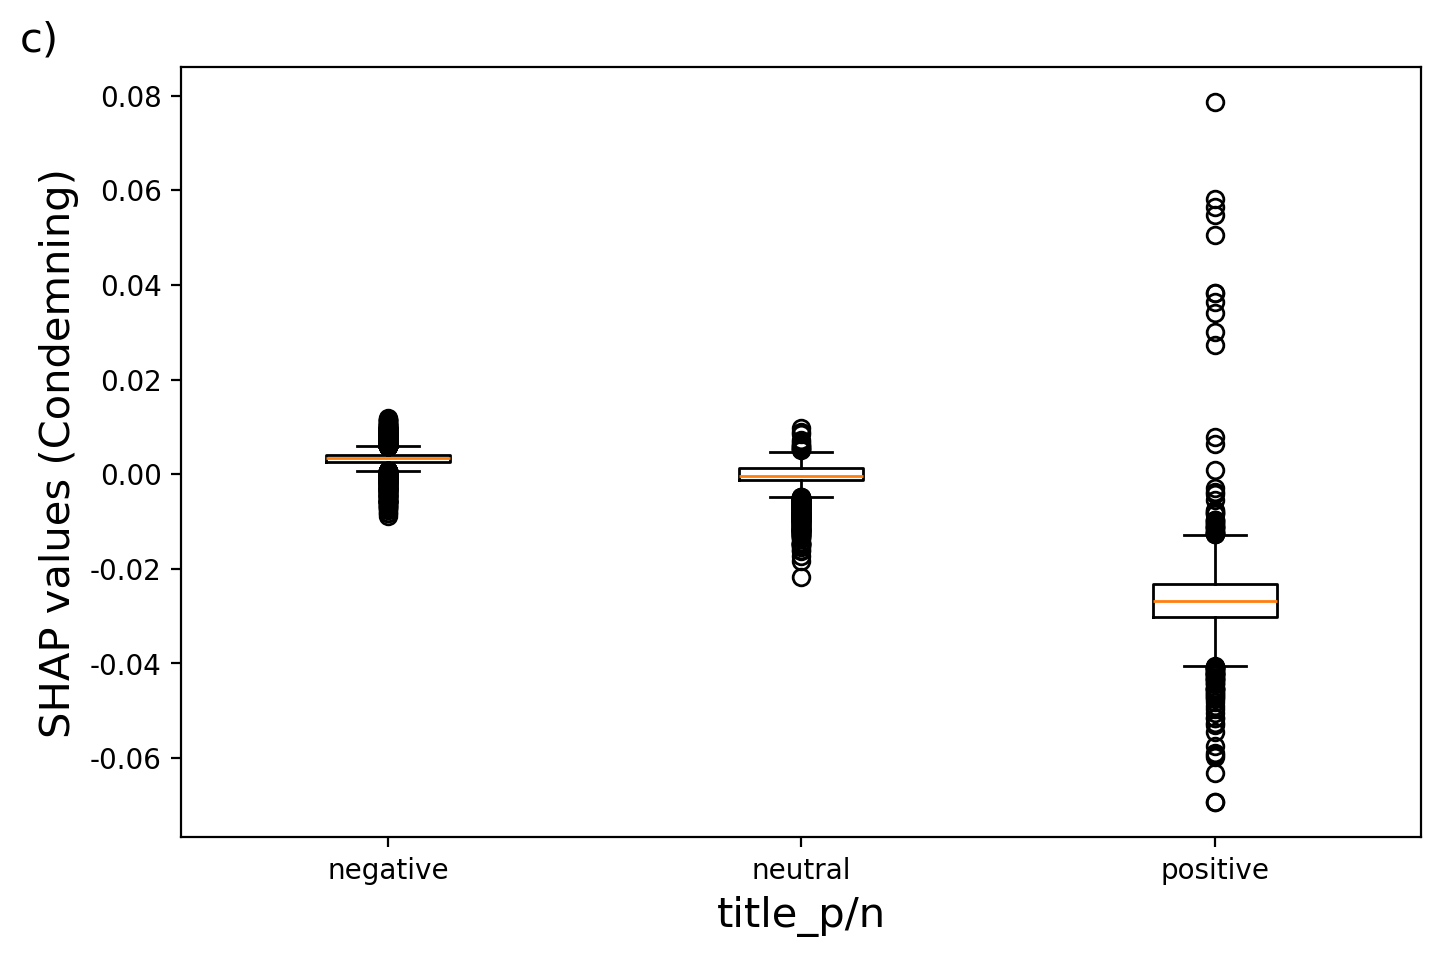

In [104]:
#get shaply values and data
# odor_values = shap_values_1[:,'title_p/n'].values
# odor_data = X_1['title_p/n']
# unique_odor = set(X['title_p/n'])

#split odor shap values based on odor category
odor_categories = sorted(list(set(odor_data)))

odor_groups = []
for o in odor_categories:
    relevant_values = odor_values[odor_data == o]
    odor_groups.append(relevant_values)
    
# #replace categories with labels
# odor_labels = {'a':'almond',
#                'l':'anise', 
#                'c':'creosote', 
#                'y':'fishy', 
#                'f':'foul', 
#                'm':'musty', 
#                'n':'none', 
#                'p':'pungent', 
#                's':'spicy'}

# labels = [odor_labels[u] for u in unique_odor]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(odor_groups,labels=odor_categories)

plt.ylabel('SHAP values (Condemning)',size=15)
plt.xlabel('title_p/n',size=15)

# Setting the title with custom alignment
title = plt.title("c)", fontsize=15)
title.set_position([-0.13,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')
plt.show()

### Model 2: Dependent variable "token_len"

In [68]:
# Creating data features.
X_2 = df[['user_type', 'title_p/n', 'e_policy_p/n', 
        'politics', 'economy','society', 'culture', 'international', 'sports', 'IT_science', \
        # 'Condemning', 
        # 'Praising', 'Suffering','Self-Conscious',\
        'Condemning_past','Praising_past', 'Suffering_past', 'Self-Conscious_past',
        'tokens_len_past', 'ttr_past']]
y_2 = df['tokens_len']

In [69]:
# Splitting data into training and testing sets
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=2023)

# Specifying indices of categorical features
cat_features = [0,1,2]

In [70]:
# Convert to CatBoost Pool format
train_pool_2 = Pool(X_train_2, y_train_2, cat_features=cat_features)
test_pool_2 = Pool(X_test_2, y_test_2, cat_features=cat_features)

In [71]:
# Model initialization
model_2 = CatBoostRegressor(iterations=1000, learning_rate=0.1, verbose=200)

In [72]:
# Train
model_2.fit(train_pool_2, eval_set=test_pool_2)

0:	learn: 30.0676732	test: 30.1213385	best: 30.1213385 (0)	total: 11.7ms	remaining: 11.7s
200:	learn: 24.1518565	test: 25.1068367	best: 25.1050955 (194)	total: 1.44s	remaining: 5.73s
400:	learn: 23.3986504	test: 25.0815333	best: 25.0706277 (364)	total: 2.85s	remaining: 4.25s
600:	learn: 22.7499652	test: 25.1215023	best: 25.0706277 (364)	total: 4.27s	remaining: 2.84s
800:	learn: 22.1923338	test: 25.1379638	best: 25.0706277 (364)	total: 5.7s	remaining: 1.42s
999:	learn: 21.7122969	test: 25.1897363	best: 25.0706277 (364)	total: 7.11s	remaining: 0us

bestTest = 25.0706277
bestIteration = 364

Shrink model to first 365 iterations.


In [48]:
# model save
# model_2.save_model('./catboost_model/token_len.model')

In [105]:
# Predict
y_pred_2 = model_2.predict(X_test_2)

# R-squared
print("R-squared: {:.3f}".format(r2_score(y_test_2, y_pred_2)))

# Adjusted R2
n = X_test_2.shape[0]
k = X_test_2.shape[1]
adjusted_r2 = 1 - (1 - r2_score(y_test_2, y_pred_2)) * (n - 1) / (n - k - 1)
print("Adj R-squared: {:.3f}".format(adjusted_r2))

# MAPE
print("MAPE: {:.3f}".format(mean_absolute_percentage_error(y_test_2, y_pred_2)))

# Normalized MAE
# Calculate MAE
mae = np.mean(np.abs(y_test_2 - y_pred_2))
# Normalize MAE by the range of the dependent variable (Max - Min)
normalized_mae_range = mae / (np.max(y_test_2) - np.min(y_test_2))

# Normalize MAE by the standard deviation of the dependent variable
normalized_mae_std = mae / np.std(y_test_2)
print("Normalized MAE: {:.3f}".format(normalized_mae_range))
print("Normalized_std MAE: {:.3f}".format(normalized_mae_std))

# Calculate Coefficient of Variation of the RMSE (CV-RMSE)
print("CV-RMSE: {:.3f}".format(mean_squared_error(y_test_2, y_pred_2, squared=False) / np.mean(y_test_2)))

R-squared: 0.346
Adj R-squared: 0.345
MAPE: 1.098
Normalized MAE: 0.085
Normalized_std MAE: 0.552
CV-RMSE: 0.783


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


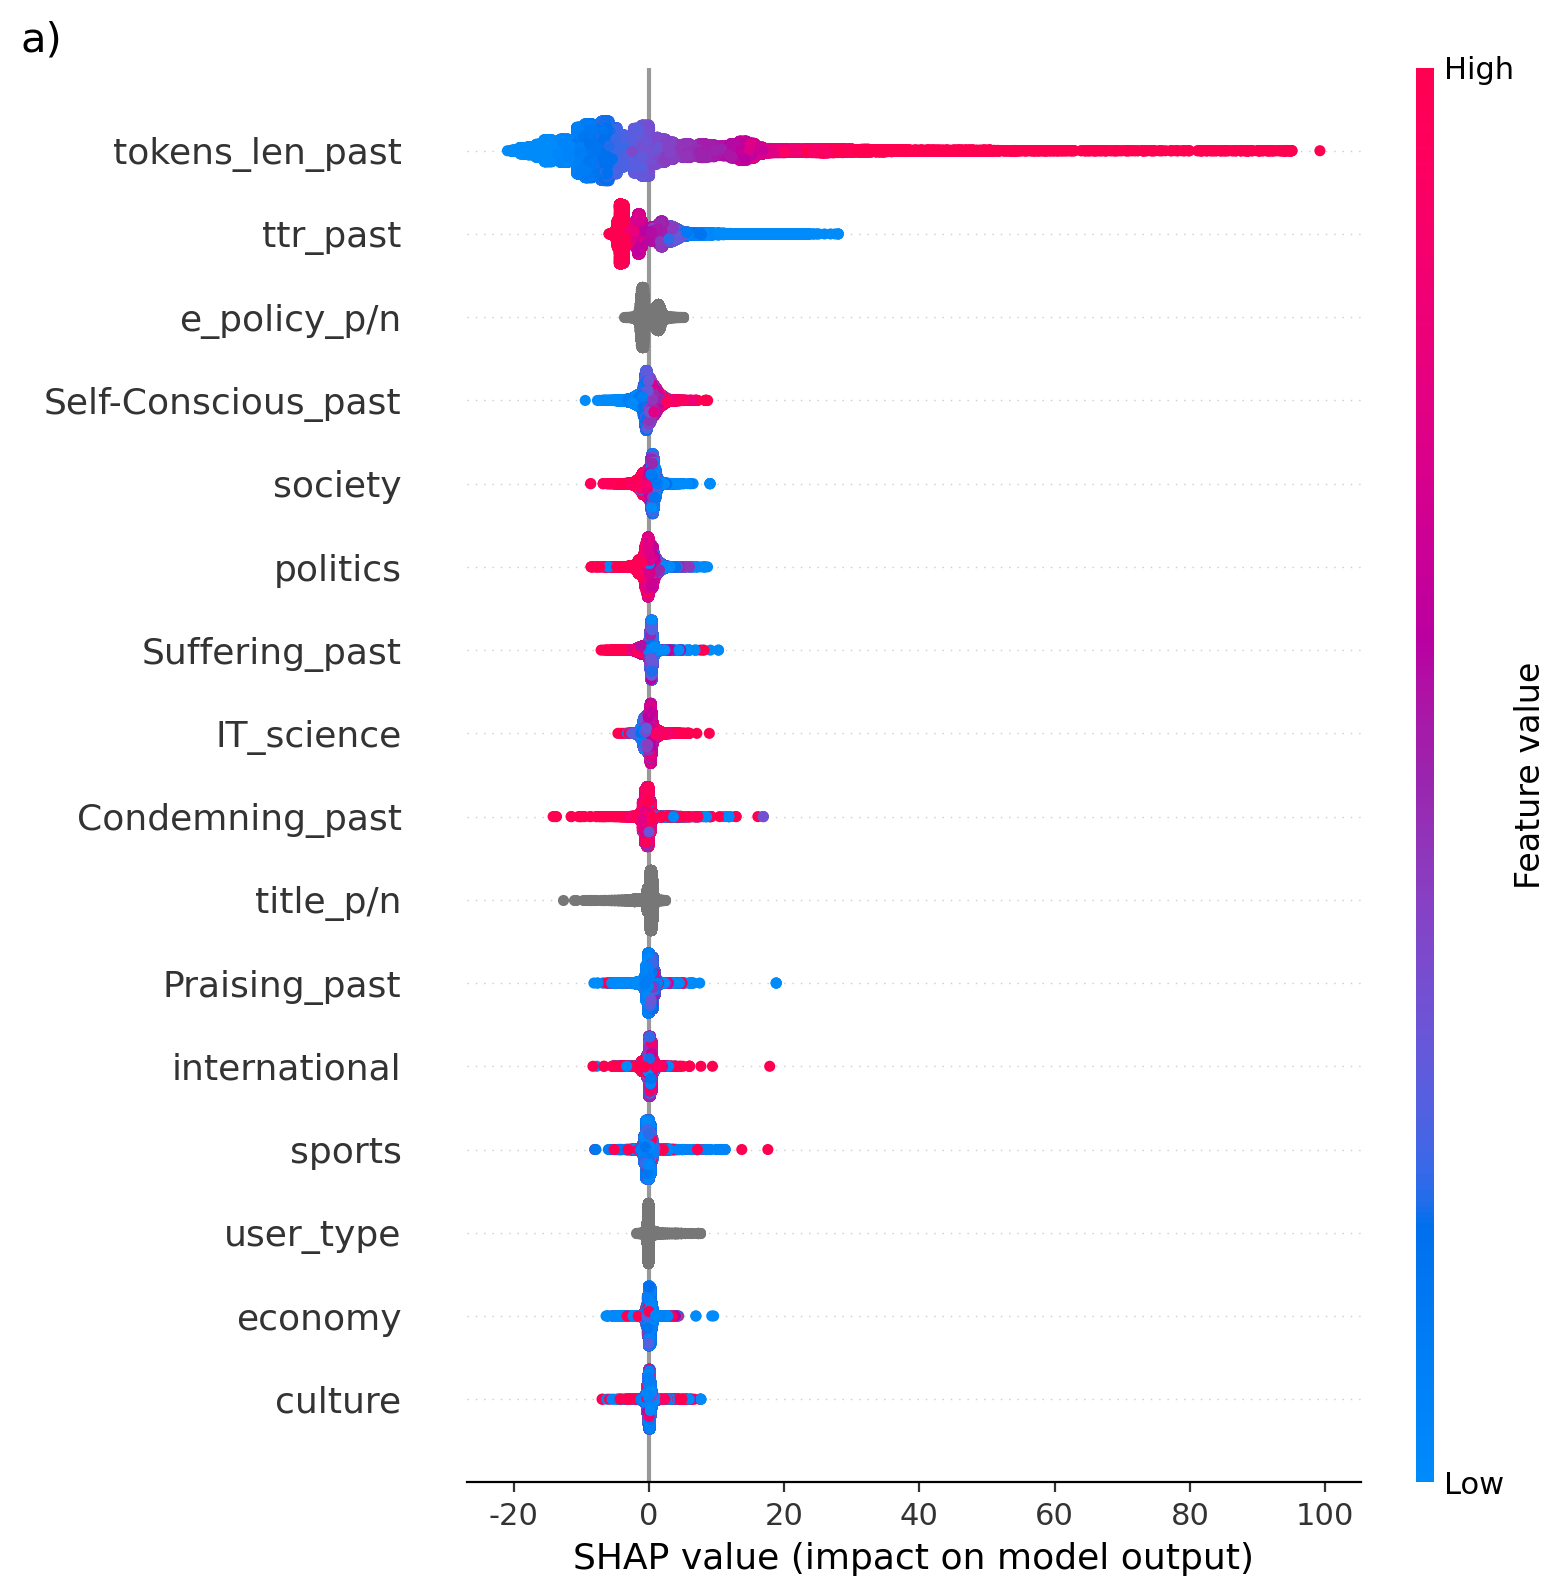

In [107]:
# Get and plot SHAP values
explainer_2 = shap.Explainer(model_2)
shap_values_2 = explainer_2(X_2)
shap.summary_plot(shap_values_2, X_2,show=False)

# Setting the title with custom alignment
title = plt.title("a)", fontsize=15)
title.set_position([-0.5,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')
plt.show()

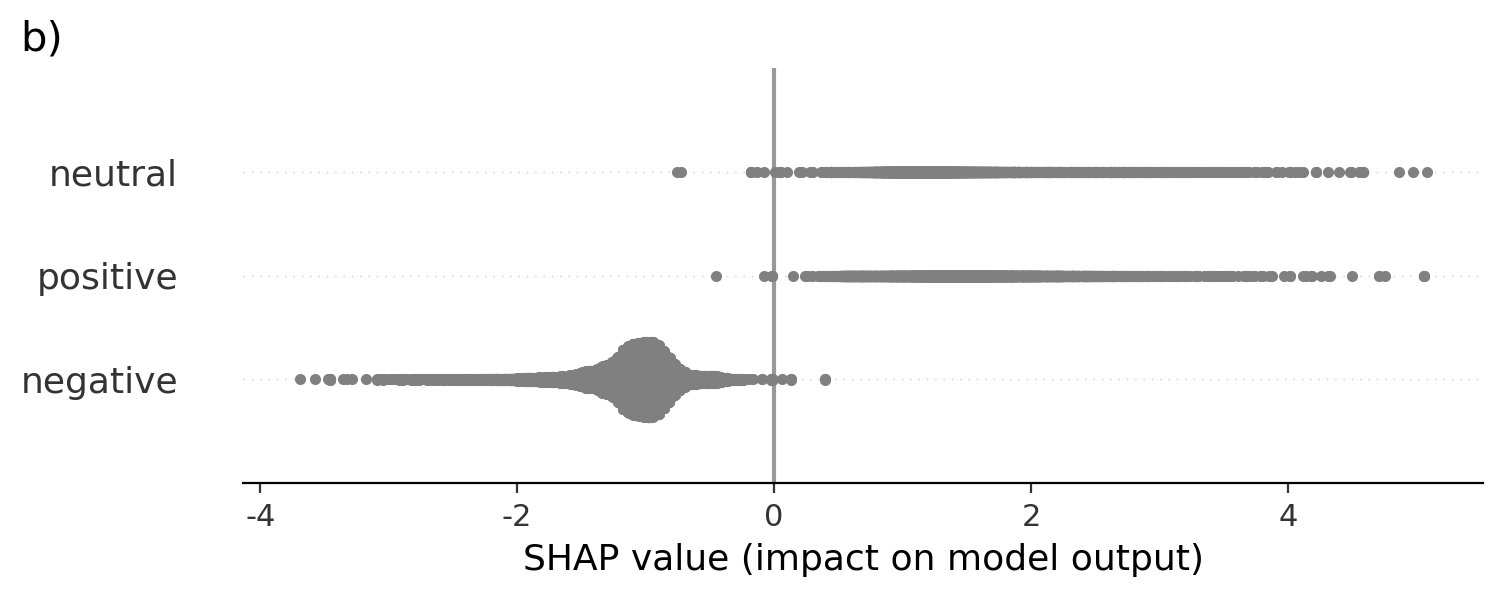

In [110]:
#Create for placeholder SHAP values
shap_values_cate_2 = explainer_2(X_2)

#Get shaply values and feature values for odor
odor_values = np.array(shap_values_2[:,'e_policy_p/n'].values) 
odor_data = X_2['e_policy_p/n']

#Create new SHAP values array

#Split odor SHAP values by unique odor categories
unique_odor = list(X_2['e_policy_p/n'].unique())
new_shap_values = [np.array(pd.Series(odor_values)[odor_data==odor]) for odor in unique_odor]

#Each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

#replace shap values
shap_values_cate_2.values = np.array(new_shap_values)

#replace data with placeholder array
shap_values_cate_2.data = np.array([[0]*len(unique_odor)]*max_len)

#replace base data with placeholder array
shap_values_cate_2.base = np.array([0]*max_len)

#replace feature names with category labels
# odor_labels = {'a':'almond',
#                'l':'anise', 
#                'c':'creosote', 
#                'y':'fishy', 
#                'f':'foul', 
#                'm':'musty', 
#                'n':'none', 
#                'p':'pungent', 
#                's':'spicy'}
# labels = ["{} ({})".format(odor_labels[u],u) for u in unique_odor]
shap_values_cate_2.feature_names = unique_odor

#Use besswarm as before
shap.plots.beeswarm(shap_values_cate_2, color_bar=False,show=False,color='#808080')

# Setting the title with custom alignment
title = plt.title("b)", fontsize=15)
title.set_position([-0.18,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')

plt.show()

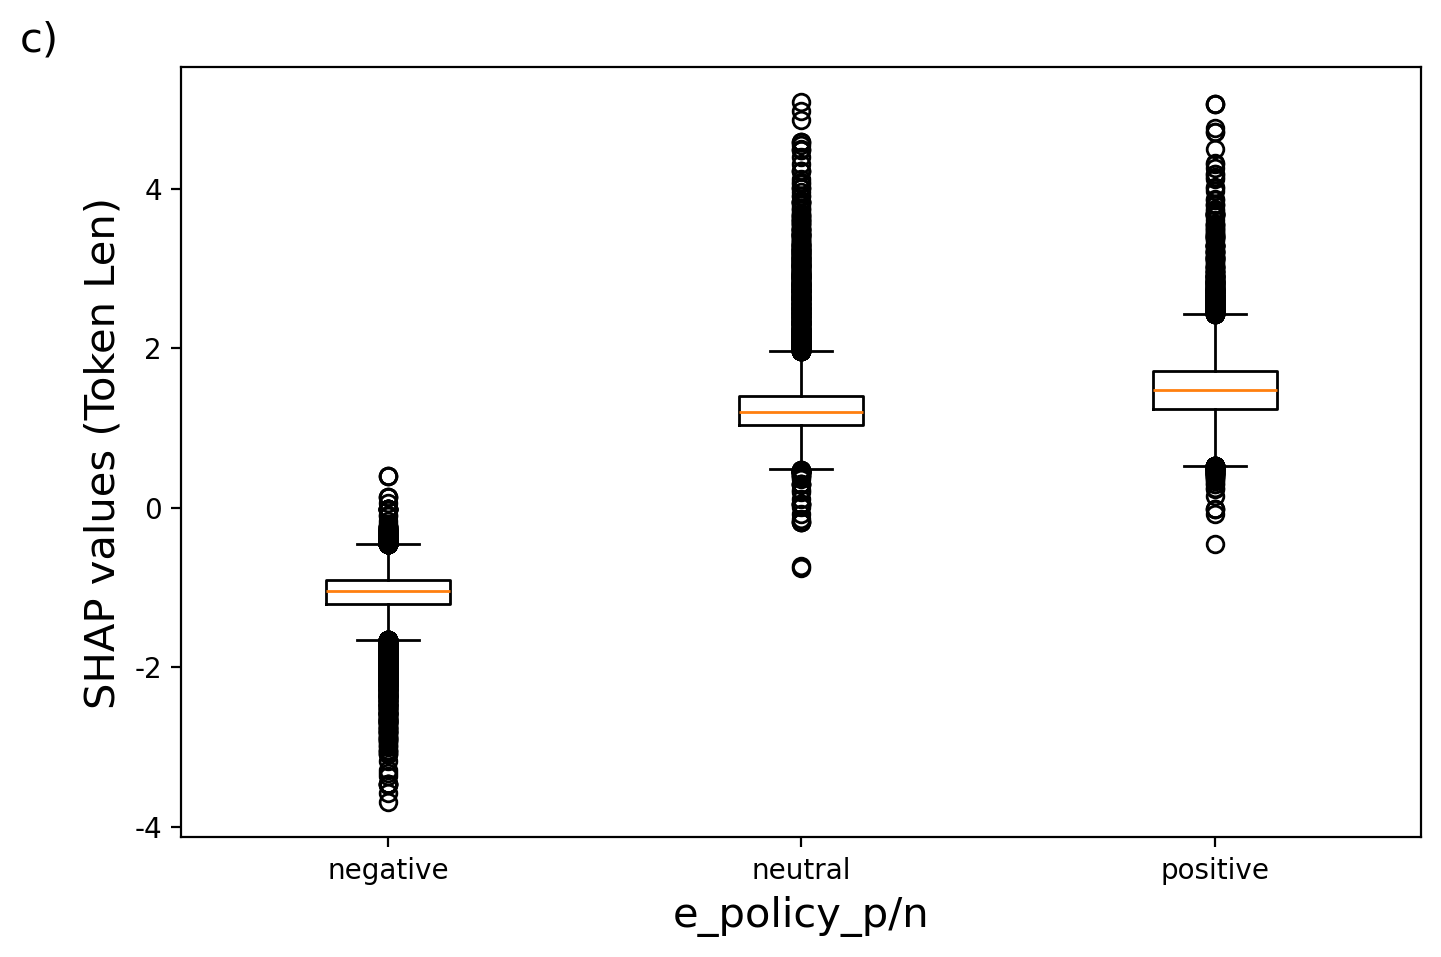

In [111]:
#get shaply values and data
# odor_values = shap_values[:,'e_policy_p/n'].values
# odor_data = X['e_policy_p/n']
# unique_odor = set(X['e_policy_p/n'])

#split odor shap values based on odor category
odor_categories = sorted(list(set(odor_data)))

odor_groups = []
for o in odor_categories:
    relevant_values = odor_values[odor_data == o]
    odor_groups.append(relevant_values)
    
# #replace categories with labels
# odor_labels = {'a':'almond',
#                'l':'anise', 
#                'c':'creosote', 
#                'y':'fishy', 
#                'f':'foul', 
#                'm':'musty', 
#                'n':'none', 
#                'p':'pungent', 
#                's':'spicy'}

# labels = [odor_labels[u] for u in unique_odor]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(odor_groups,labels=odor_categories)

plt.ylabel('SHAP values (Token Len)',size=15)
plt.xlabel('e_policy_p/n',size=15)

# Setting the title with custom alignment
title = plt.title("c)", fontsize=15)
title.set_position([-0.13,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')

plt.show()

### Model 3: Dependent variable "ttr"

In [49]:
# Creating data features.
X_3 = df[['user_type', 'title_p/n', 'e_policy_p/n', 'politics', 'economy',\
       'society', 'culture', 'international', 'sports', 'IT_science', \
        # 'Praising', 'Suffering','Self-Conscious',\
        'Condemning_past','Praising_past', 'Suffering_past', 'Self-Conscious_past',
        'tokens_len_past', 'ttr_past']]
y_3 = df['ttr']

In [50]:
# Splitting data into training and testing sets
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=2023)

# Specifying indices of categorical features
cat_features = [0,1,2]

In [51]:
# Convert to CatBoost Pool format.
train_pool_3 = Pool(X_train_3, y_train_3, cat_features=cat_features)
test_pool_3 = Pool(X_test_3, y_test_3, cat_features=cat_features)

In [52]:
# Model initialization
model_3 = CatBoostRegressor(iterations=1000, learning_rate=0.1, verbose=200)

In [53]:
# Train
model_3.fit(train_pool_3, eval_set=test_pool_3)

0:	learn: 0.0989996	test: 0.0993236	best: 0.0993236 (0)	total: 10.2ms	remaining: 10.2s
200:	learn: 0.0860499	test: 0.0880874	best: 0.0880803 (197)	total: 1.39s	remaining: 5.51s
400:	learn: 0.0837941	test: 0.0881700	best: 0.0880758 (208)	total: 2.79s	remaining: 4.16s
600:	learn: 0.0819299	test: 0.0882813	best: 0.0880758 (208)	total: 4.19s	remaining: 2.78s
800:	learn: 0.0802180	test: 0.0884940	best: 0.0880758 (208)	total: 5.58s	remaining: 1.39s
999:	learn: 0.0787179	test: 0.0886312	best: 0.0880758 (208)	total: 6.98s	remaining: 0us

bestTest = 0.08807582236
bestIteration = 208

Shrink model to first 209 iterations.


In [19]:
# model save
# model_3.save_model('./catboost_model/token_ttr.model')

In [98]:
# Predict
y_pred_3 = model_3.predict(X_test_3)

# R-squared
print("R-squared: {:.3f}".format(r2_score(y_test_3, y_pred_3)))

# Adjusted R2
n = X_test_3.shape[0]
k = X_test_3.shape[1]
adjusted_r2 = 1 - (1 - r2_score(y_test_3, y_pred_3)) * (n - 1) / (n - k - 1)
print("Adj R-squared: {:.3f}".format(adjusted_r2))

# MAPE
print("MAPE: {:.3f}".format(mean_absolute_percentage_error(y_test_3, y_pred_3)))

# Normalized MAE
# Calculate MAE
mae = np.mean(np.abs(y_test_3 - y_pred_3))
# Normalize MAE by the range of the dependent variable (Max - Min)
normalized_mae_range = mae / (np.max(y_test_3) - np.min(y_test_3))

# Normalize MAE by the standard deviation of the dependent variable
normalized_mae_std = mae / np.std(y_test_3)
print("Normalized MAE: {:.3f}".format(normalized_mae_range))
print("Normalized_std MAE: {:.3f}".format(normalized_mae_std))

# Calculate Coefficient of Variation of the RMSE (CV-RMSE)
print("CV-RMSE: {:.3f}".format(mean_squared_error(y_test_3, y_pred_3, squared=False) / np.mean(y_test_3)))

R-squared: 0.245
Adj R-squared: 0.244
MAPE: 0.085
Normalized MAE: 0.075
Normalized_std MAE: 0.691
CV-RMSE: 0.097


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


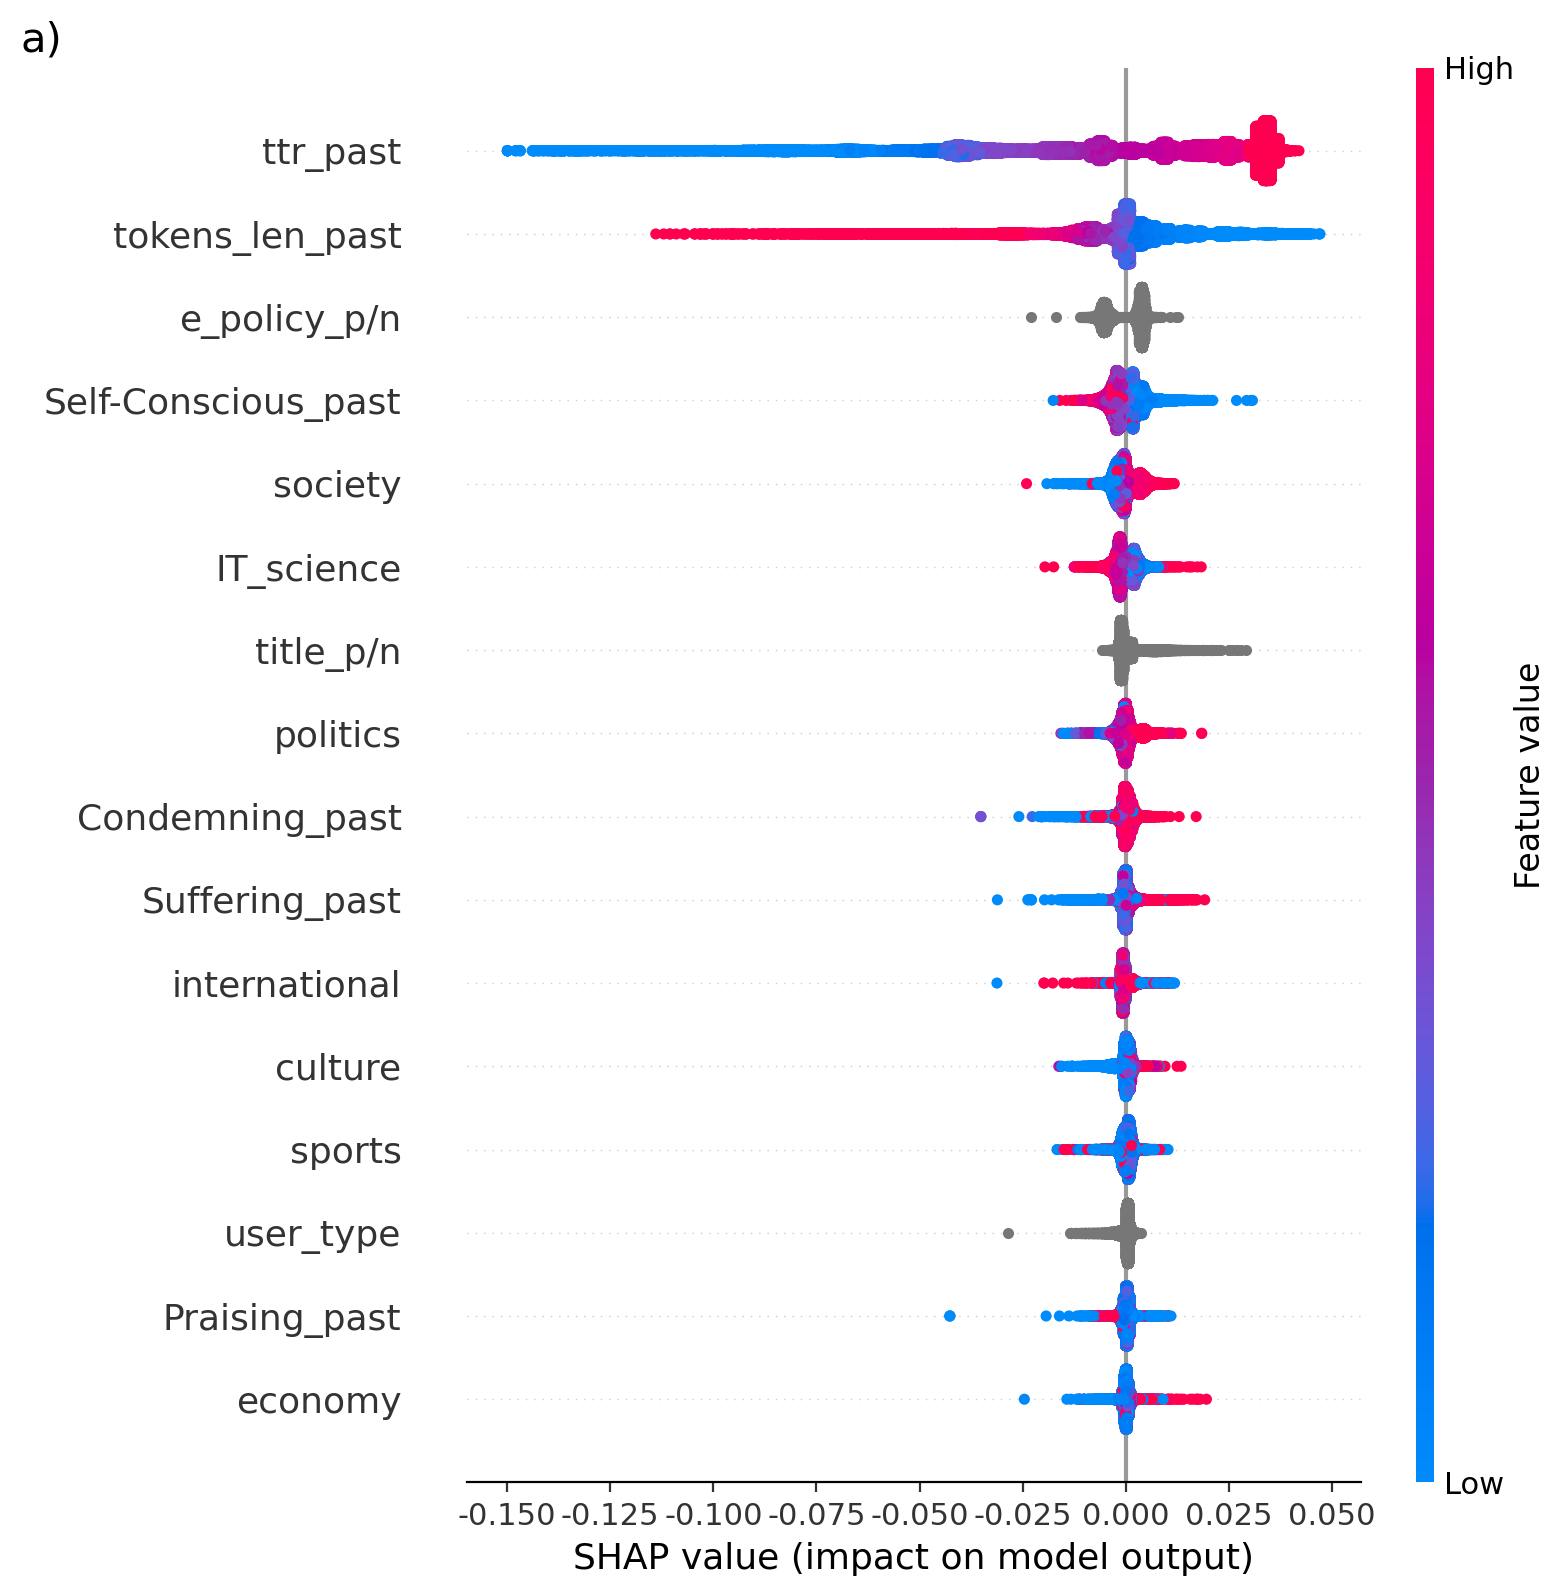

In [112]:
# Get and plot SHAP values
explainer_3 = shap.Explainer(model_3)
shap_values_3 = explainer_3(X_3)
shap.summary_plot(shap_values_3, X_3, show=False)

# Setting the title with custom alignment
title = plt.title("a)", fontsize=15)
title.set_position([-0.5,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')
plt.show()

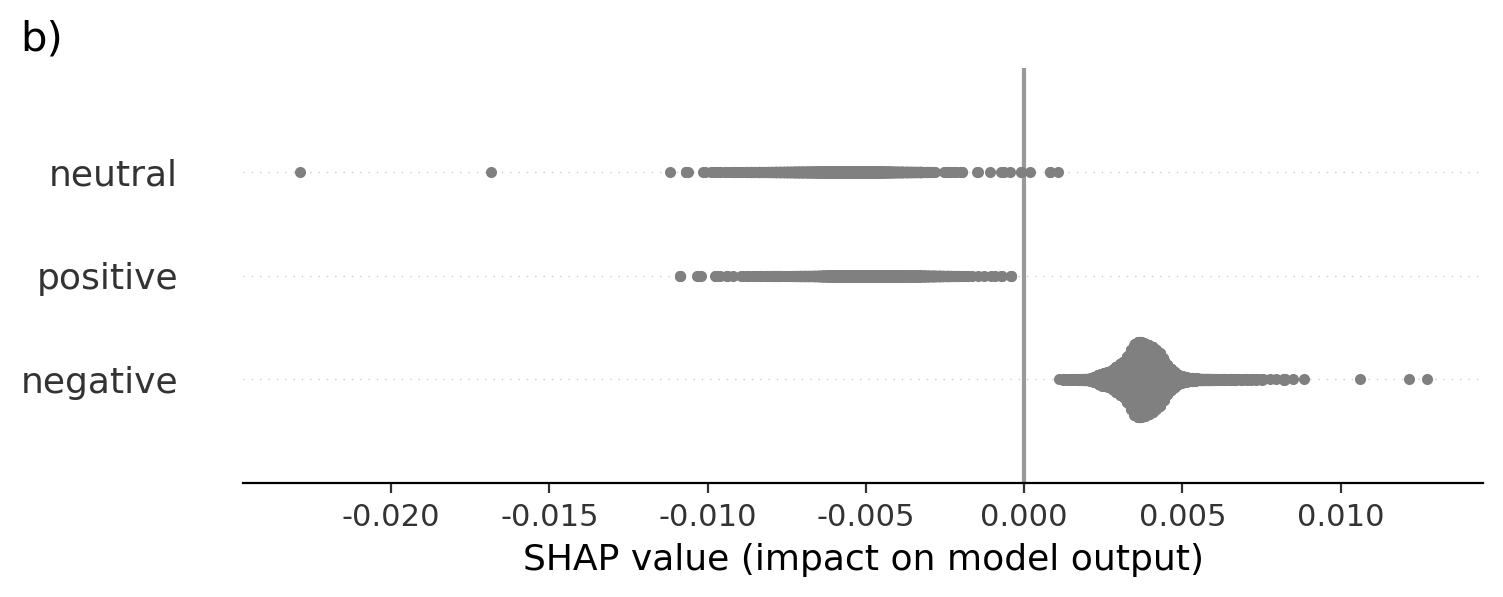

In [115]:
#Create for placeholder SHAP values
shap_values_cate_3 = explainer_3(X_3)

#Get shaply values and feature values for odor
odor_values = np.array(shap_values_3[:,'e_policy_p/n'].values) 
odor_data = X_3['e_policy_p/n']

#Create new SHAP values array

#Split odor SHAP values by unique odor categories
unique_odor = list(X_3['e_policy_p/n'].unique())
new_shap_values = [np.array(pd.Series(odor_values)[odor_data==odor]) for odor in unique_odor]

#Each sublist needs to be the same length
max_len = max([len(v) for v in new_shap_values])
new_shap_values = [np.append(vs,[np.nan]*(max_len - len(vs))) for vs in new_shap_values]
new_shap_values = np.array(new_shap_values)

#transpost matrix so categories are columns and SHAP values are rows
new_shap_values = new_shap_values.transpose()

#replace shap values
shap_values_cate_3.values = np.array(new_shap_values)

#replace data with placeholder array
shap_values_cate_3.data = np.array([[0]*len(unique_odor)]*max_len)

#replace base data with placeholder array
shap_values_cate_3.base = np.array([0]*max_len)

#replace feature names with category labels
# odor_labels = {'a':'almond',
#                'l':'anise', 
#                'c':'creosote', 
#                'y':'fishy', 
#                'f':'foul', 
#                'm':'musty', 
#                'n':'none', 
#                'p':'pungent', 
#                's':'spicy'}
# labels = ["{} ({})".format(odor_labels[u],u) for u in unique_odor]
shap_values_cate_3.feature_names = unique_odor

#Use besswarm as before
shap.plots.beeswarm(shap_values_cate_3, color_bar=False,show=False,color='#808080')

# Setting the title with custom alignment
title = plt.title("b)", fontsize=15)
title.set_position([-0.18,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')

plt.show()

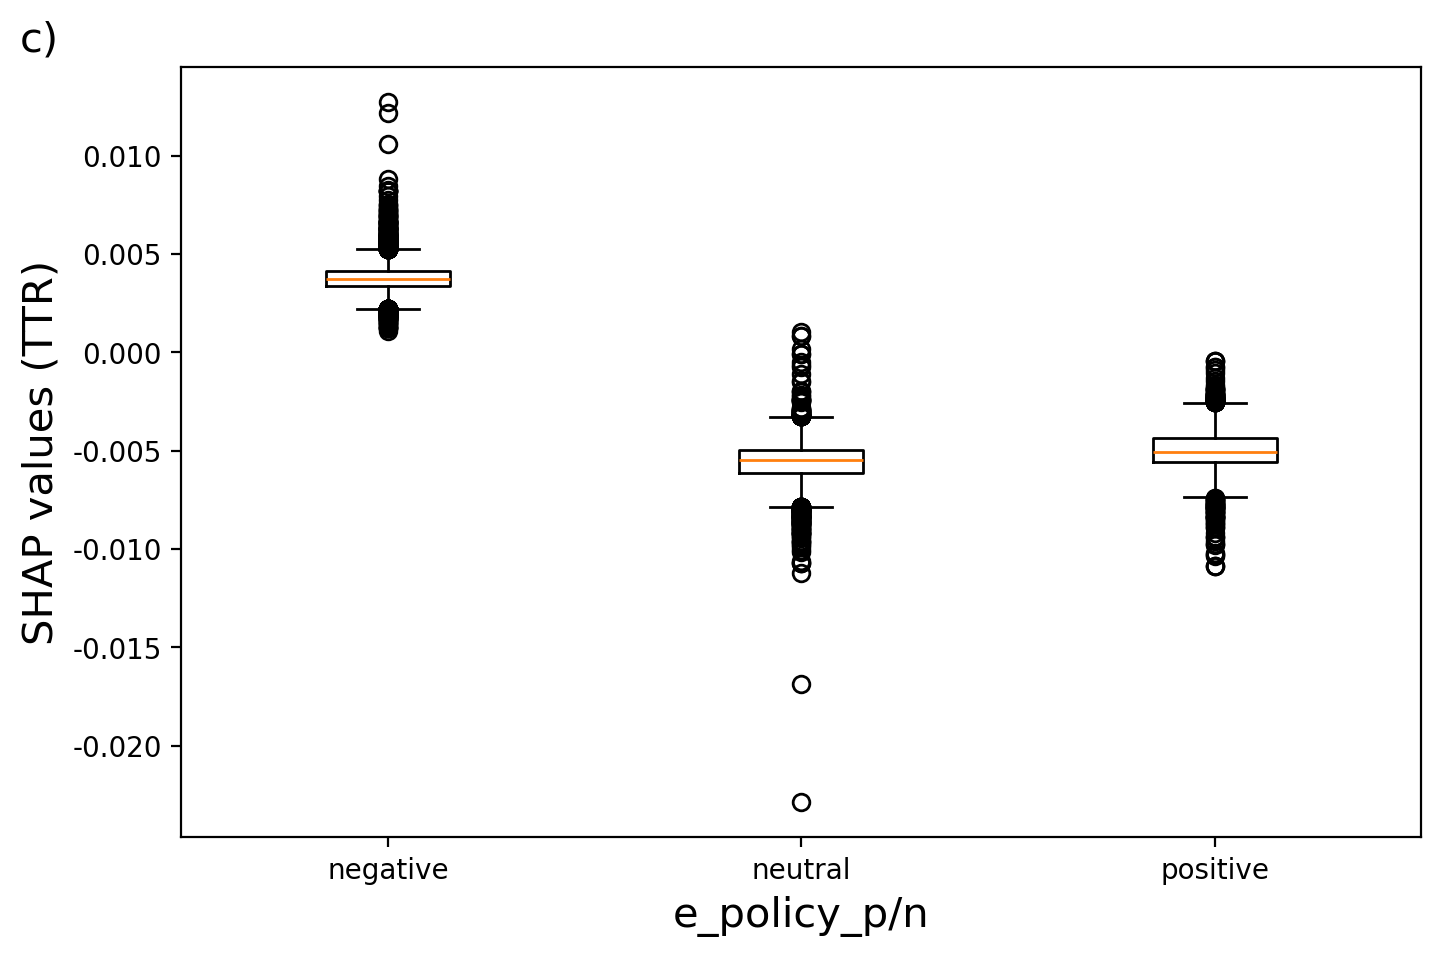

In [116]:
#get shaply values and data
# odor_values = shap_values[:,'e_policy_p/n'].values
# odor_data = X['e_policy_p/n']
# unique_odor = set(X['e_policy_p/n'])

#split odor shap values based on odor category
odor_categories = sorted(list(set(odor_data)))

odor_groups = []
for o in odor_categories:
    relevant_values = odor_values[odor_data == o]
    odor_groups.append(relevant_values)
    
# #replace categories with labels
# odor_labels = {'a':'almond',
#                'l':'anise', 
#                'c':'creosote', 
#                'y':'fishy', 
#                'f':'foul', 
#                'm':'musty', 
#                'n':'none', 
#                'p':'pungent', 
#                's':'spicy'}

# labels = [odor_labels[u] for u in unique_odor]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(odor_groups,labels=odor_categories)

plt.ylabel('SHAP values (TTR)',size=15)
plt.xlabel('e_policy_p/n',size=15)

# Setting the title with custom alignment
title = plt.title("c)", fontsize=15)
title.set_position([-0.13,1]) # You can adjust the [0, 1.02] values as needed
title.set_ha('left')

plt.show()